<a href="https://colab.research.google.com/github/thmswhelan/UCDPA_ThomasWhelan/blob/main/PropertyPricesIreland.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

url = "https://raw.githubusercontent.com/thmswhelan/UCDPA_ThomasWhelan/main/Property_Price_Register_Ireland-28-05-2021.csv"

df = pd.read_csv(url)

In [ ]:
df.head()

,SALE_DATE,ADDRESS,POSTAL_CODE,COUNTY,SALE_PRICE,IF_MARKET_PRICE,IF_VAT_EXCLUDED,PROPERTY_DESC,PROPERTY_SIZE_DESC
0,2010-01-01,"5 Braemor Drive, Churchtown, Co.Dublin",NaN,Dublin,343000.0,0,0,Second-Hand Dwelling house /Apartment,NaN
1,2010-01-03,"134 Ashewood Walk, Summerhill Lane, Portlaoise",NaN,Laois,185000.0,0,1,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...
2,2010-01-04,"1 Meadow Avenue, Dundrum, Dublin 14",NaN,Dublin,438500.0,0,0,Second-Hand Dwelling house /Apartment,NaN
3,2010-01-04,"1 The Haven, Mornington",NaN,Meath,400000.0,0,0,Second-Hand Dwelling house /Apartment,NaN
4,2010-01-04,"11 Melville Heights, Kilkenny",NaN,Kilkenny,160000.0,0,0,Second-Hand Dwelling house /Apartment,NaN


In [37]:
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [40]:
df.dtypes

SALE_DATE             datetime64[ns]
ADDRESS                       object
POSTAL_CODE                   object
COUNTY                        object
SALE_PRICE                   float64
IF_MARKET_PRICE                int64
IF_VAT_EXCLUDED                int64
PROPERTY_DESC                 object
PROPERTY_SIZE_DESC            object
year                           int64
dtype: object

In [41]:
df['year'] = df['SALE_DATE'].dt.year
df.dtypes

SALE_DATE             datetime64[ns]
ADDRESS                       object
POSTAL_CODE                   object
COUNTY                        object
SALE_PRICE                   float64
IF_MARKET_PRICE                int64
IF_VAT_EXCLUDED                int64
PROPERTY_DESC                 object
PROPERTY_SIZE_DESC            object
year                           int64
dtype: object

In [42]:
df.describe()

,SALE_PRICE,IF_MARKET_PRICE,IF_VAT_EXCLUDED,year
count,4.767450e+05,476745.000000,476745.000000,476745.000000
mean,2.590403e+05,0.048984,0.159618,2016.191037
std,8.526791e+05,0.215835,0.366252,2.958550
min,5.030530e+03,0.000000,0.000000,2010.000000
25%,1.150000e+05,0.000000,0.000000,2014.000000
50%,1.950000e+05,0.000000,0.000000,2017.000000
75%,3.000000e+05,0.000000,0.000000,2019.000000
max,1.701428e+08,1.000000,1.000000,2021.000000


In [43]:
df.value_counts()

SALE_DATE   ADDRESS                                                   POSTAL_CODE  COUNTY  SALE_PRICE  IF_MARKET_PRICE  IF_VAT_EXCLUDED  PROPERTY_DESC                  PROPERTY_SIZE_DESC                                                 year
2013-12-20  2 Phoenix Park Way, Phoenix Park Racecourse, Castleknock  Dublin 15    Dublin  8000.00     0                1                New Dwelling house /Apartment  greater than or equal to 38 sq metres and less than 125 sq metres  2013    4
2013-11-20  Apt. 9 Red Arches Park, The Coast, Baldoyle               Dublin 13    Dublin  127753.30   0                1                New Dwelling house /Apartment  greater than or equal to 38 sq metres and less than 125 sq metres  2013    3
2013-12-20  77 Rosanule, Phoenix Park Racecourse, Castleknock         Dublin 15    Dublin  8000.00     0                1                New Dwelling house /Apartment  greater than or equal to 38 sq metres and less than 125 sq metres  2013    3
            4 Surehaven R

In [44]:
np.mean(df['SALE_PRICE'])

259040.30628275065

In [45]:
year_prices = df.groupby('year')

In [51]:
mean_year_prices = year_prices['SALE_PRICE'].mean()
print(mean_year_prices)

year
2010    242987.415896
2011    214662.591054
2012    193527.424412
2013    204077.028227
2014    214639.754720
2015    220156.800028
2016    244710.930623
2017    265842.958488
2018    294013.632416
2019    306995.242014
2020    313272.736809
2021    320785.455816
Name: SALE_PRICE, dtype: float64


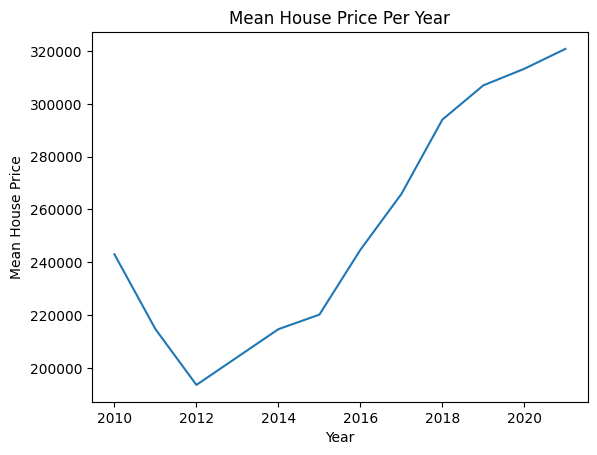

In [54]:
plt.plot(mean_year_prices.index, mean_year_prices.values)
plt.xlabel('Year')
plt.ylabel('Mean House Price')
plt.title('Mean House Price Per Year')
plt.show()